In [30]:
import numpy as np
import pandas as pd
from pandas import DataFrame as dataframe
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
# import shap

import xgboost
print(xgboost.__version__)
from xgboost import XGBClassifier

import pickle
import time

!export PYTHONPATH="/home/hendrio/amex-1M/:$PYTHONPATH"
!export PYTHONPATH="/home/hendrio/amex-1M/src/:$PYTHONPATH"


# import sys
# sys.path.append('/home/hendrio/amex-1M/')
# sys.path.append('/home/hendrio/amex-1M/src/')

import trainer

2.0.3


In [16]:
base_dir = "/home/hendrio/amex-1M/"
os.listdir(base_dir)

paths={
    'data': join(base_dir, 'data'),
    'src': join(base_dir, 'data', 'src'),
    'processed': join(base_dir, 'data', 'processed'),
    'datasets': join(base_dir, 'datasets1'),
    'results': join(base_dir,'results'),
    'images': join(base_dir,'images'),
    
}

In [48]:
def load_amex_1m(path, file_name='amex-1M_binary-dataset-[intents-permissions-apicalls].npz'):
    data_dict = np.load(join(path, file_name), allow_pickle=True)
    metadata = dataframe(data_dict['metadata'], columns=data_dict['metadata_feature_names'])
    
    columns_names = data_dict['feature_names']
    sha256 = data_dict['sha256']

    print(data_dict['data'].shape)

    if ("CLASS" not in metadata.columns):
        print()
        metadata['CLASS'] = create_class(df=metadata['VT_SCANNERS_MALICIOUS'], threshold=4)
    print(metadata['CLASS'].value_counts())

    return data_dict['data'], metadata, columns_names, sha256


def create_class(df, threshold):
    return np.asarray([1 if i>=threshold else 0 for i in df ])

In [51]:
dataset_name = 'amex-1M_binary-dataset-[intents-permissions]'

In [52]:
data, metadata, columns_names, sha256 = load_amex_1m(
    path=paths['processed'], 
    file_name=f'{dataset_name}.npz'
    )

(1340515, 416)
CLASS
0    1221421
1     119094
Name: count, dtype: int64


In [53]:
def create_datasets(data, metadata):

    X_train, X_test, y_train, y_test = train_test_split( 
        data, metadata, 
        test_size=0.30, 
        random_state=0, 
        shuffle=True
    )
    
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    encoder_binary = OneHotEncoder().fit(np.expand_dims(metadata['CLASS'].values, axis=1))
    
    data_dict = {
        'X_train': X_train,
        'y_train_metadata': y_train,
        'y_train_ohe': encoder_binary.transform(np.expand_dims(y_train['CLASS'].values, axis=1)).toarray(),
        'X_test': X_test,
        'y_test_metadata': y_test,
        'y_test_ohe': encoder_binary.transform(np.expand_dims(y_test['CLASS'].values, axis=1)).toarray(),
        'classes_names': ['Benign', 'Malware']
    }
    
    return data_dict

In [54]:
data_dict = create_datasets(data, metadata)

(938360, 416) (402155, 416) (938360, 12) (402155, 12)


In [ ]:
model, time_duration = trainer.train( 
                X=X_train.values , 
                y=data_dict['y_train_ohe'].toarray(), 
                model_name=model_name)

In [ ]:
trainer.save_model(
    model=model, 
    directory=experiment_path, 
    filename= experiment_name,
    extension=extension
    )

with open(join(experiment_path, f'{experiment_name}-time.txt'), 'w') as file:
    file.write(f'{time_duration:.4f}')
print(f"\tEvaluating {model_name}")

In [ ]:
        pred, cm, report = trainer.eval(
            X=X_test.values, 
            # y_true=np.argmax(y_test, axis=1), 
            y_true=data_dict['y_test_ohe'].toarray(), 
            model=model,
            class_labels=data_dict['classes_names'],
            dataset_name=dataset_name,
            model_name=model_name,
            path_save=experiment_path
        )

        gc.collect()

In [55]:
import gc
import trainer
def pipeline_train_models(
    data_dict, models_list, dataset_name='amex-1M', sufix_title='original', path_save=join(base_dir, 'models'), feature_list=None):

    # for dataset_name in datasets.keys():
    #     print(f'Dataset name: {dataset_name}')
    for model_name in models_list:
        print()
        print()
        print(f'=========================================================================')
        print(f'===================== Model name: {model_name} ==========================')
        print(f'=========================================================================')
        
        experiment_name = f'{dataset_name}-{model_name}-{sufix_title}'
        print('\t',experiment_name)
        experiment_path = join(path_save, experiment_name)
        
        if os.path.exists(experiment_path):
            print(f"\tExperiment already exists. ")
            print(f'\t============================================================================================')
            print(f'\t====================== Skipping {experiment_name} =====================')
            print(f'\t============================================================================================')
            continue
        else:
            os.makedirs(experiment_path)

        X_train, X_test = [], []
        if feature_list is not None:
            X_train = data_dict['X_train'][feature_list]
            X_test = data_dict['X_test'][feature_list]
        else:
            X_train = data_dict['X_train']
            X_test = data_dict['X_test']
        print(f'\tDataset shape: Train {X_train.shape}, Test {X_test.shape}')

        print(f"\tTraining {model_name}")
        model=[]
        extension='.joblib'
        if model_name=='xgboost':
            model, time_duration = trainer.train( 
                X=X_train , y=data_dict['y_train_ohe'], model_name=model_name)
            extension='.joblib'
        elif model_name=='randomforest':
            model, time_duration = trainer.train( 
                X=X_train, y=data_dict['y_train_ohe'], model_name=model_name)
            extension='.joblib'
        elif model_name=='svm':
            model, time_duration = trainer.train( 
                X=X_train, y=data_dict['y_train_ohe'], model_name=model_name)
            extension='.joblib'
        elif model_name=='knn':
            model, time_duration = trainer.train( 
                X=X_train, y=data_dict['y_train_ohe'], model_name=model_name)
            extension='.joblib'
        elif model_name=='fcn':
            model, time_duration = trainer.build_deep_model(
                X=X_train, y=data_dict['y_train_ohe'], 
                num_classes=len(data_dict['classes_names']), 
                model_name=experiment_name, 
                path_experiment=experiment_path)
            extension='.h5'

            model = tf.keras.models.load_model(join(experiment_path, f'{experiment_name}_loss.keras'))
        else:
            raise Exception (f'Model Not Found on pipeline_train_models()')
            os.remove(experiment_path)
            return []

        trainer.save_model(
            model=model, 
            directory=experiment_path, 
            filename= experiment_name,
            # extension=extension
            )
        
        with open(join(experiment_path, f'{experiment_name}-time.txt'), 'w') as file:
            file.write(f'{time_duration:.4f}')
        print(f"\tEvaluating {model_name}")
        
        pred, cm, report = trainer.eval(
            X=X_test, 
            # y_true=np.argmax(y_test, axis=1), 
            y_true=data_dict['y_test_ohe'], 
            model=model,
            class_labels=data_dict['classes_names'],
            dataset_name=dataset_name,
            model_name=model_name,
            path_save=experiment_path
        )

        gc.collect()

        print('---------------------------------------------------------------------------------------------------------------')
        print('')
        print('')

In [46]:
dataset_name

'amex-1M_binary-dataset-[intents]'



===================== Model name: xgboost ==========================
	 amex-1M_binary-dataset-[intents-permissions]-xgboost-
	Dataset shape: Train (938360, 416), Test (402155, 416)
	Training xgboost
Took 49.4781 seconds to train the xgboost
	Evaluating xgboost
(402155,) (402155,)

              precision    recall  f1-score   support

           0     0.9108    1.0000    0.9533    366286
           1     0.0000    0.0000    0.0000     35869

    accuracy                         0.9108    402155
   macro avg     0.4554    0.5000    0.4767    402155
weighted avg     0.8296    0.9108    0.8683    402155

---------------------------------------------------------------------------------------------------------------




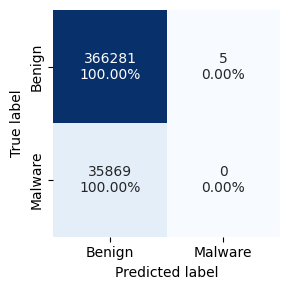

In [56]:
pipeline_train_models(
    data_dict=data_dict, 
    models_list=['xgboost'], #'knn', 'svm'
    dataset_name='amex-1M_binary-dataset-[intents-permissions]', 
    sufix_title='', 
    path_save=join(base_dir, 'results', 'models'),
    feature_list = None
)